In [1]:
import argparse
import logging 
import pandas as pd 
import numpy as np 
#!pip install pandasql
import pandasql as ps 
from urllib.parse import urlparse , parse_qs
#from pyspark.sql import sparkSession
#!pip install json_lines 
import json_lines 
import json 
#!pip install seaborn
import seaborn as sns 


# Read CSV 

In [2]:
v_input_file_name = "data.csv"
source_df = pd.read_csv(v_input_file_name)
source_df.head()
     


,anonymous_user_id,url,time,browser,os,screen_resolution
0,b527ad6c-1e79-4ae7-8206-2bf4d127ec25,https://preview.hs-sites.com/_hcms/preview/tem...,1523551855,Chrome,Linux,800x600
1,2847753f-df48-4367-98dc-9028f6330532,https://www.cultureamp.com/employee-feedback/?...,1523549796,Chrome,Chrome OS,1366x768
2,7540e6a6-bd75-4f2b-b774-6309bda47c4f,https://www.cultureamp.com/,1523549868,Chrome,Mac OS X,2560x1440
3,db016ab6-daa3-45fb-84e6-7e6e4e1541ac,https://www.cultureamp.com/products/employee-e...,1523549913,Chrome,Mac OS X,1440x900
4,864557aa-10c5-4efa-a53e-33f7b8f1bd3c,https://www.cultureamp.com/employee-feedback/,1523548907,Chrome,Windows 8.1,1366x768


In [3]:
source_df.dtypes
source_df['time']=(pd.to_datetime(source_df['time'],unit='s')) 
source_df.head()

,anonymous_user_id,url,time,browser,os,screen_resolution
0,b527ad6c-1e79-4ae7-8206-2bf4d127ec25,https://preview.hs-sites.com/_hcms/preview/tem...,2018-04-12 16:50:55,Chrome,Linux,800x600
1,2847753f-df48-4367-98dc-9028f6330532,https://www.cultureamp.com/employee-feedback/?...,2018-04-12 16:16:36,Chrome,Chrome OS,1366x768
2,7540e6a6-bd75-4f2b-b774-6309bda47c4f,https://www.cultureamp.com/,2018-04-12 16:17:48,Chrome,Mac OS X,2560x1440
3,db016ab6-daa3-45fb-84e6-7e6e4e1541ac,https://www.cultureamp.com/products/employee-e...,2018-04-12 16:18:33,Chrome,Mac OS X,1440x900
4,864557aa-10c5-4efa-a53e-33f7b8f1bd3c,https://www.cultureamp.com/employee-feedback/,2018-04-12 16:01:47,Chrome,Windows 8.1,1366x768


In [4]:
pd.set_option('display.max_colwidth', None)
sql = "select url from source_df where URL like '%utm%'"
out  = ps.sqldf(sql)
out.head()
#out.isnull().values.any() 

,url
0,https://www.cultureamp.com/employee-feedback/?utm_medium=cpc&utm_source=google&utm_campaign=&utm_term=kwd-0&utm_content=251415612391&gclid=EAIaIQobChMImLqL7ZC12gIVpPbhCh29fw1oEAEYASAAEgKwq_D_BwE
1,https://www.cultureamp.com/employee-feedback/?utm_medium=cpc&utm_source=google&utm_campaign=Display%7CReM&utm_term=aud-379099446433&utm_content=229739900304&gclid=EAIaIQobChMIltKQzpC12gIVHbtPCh1A7g8OEAEYASAAEgLYAPD_BwE
2,https://www.cultureamp.com/employee-feedback/?utm_medium=cpc&utm_source=google&utm_campaign=Display|ReM&utm_term=aud-375309830359&utm_content=229779769639&gclid=EAIaIQobChMI_96wmJa12gIVTDxPCh3eoQN5EAEYASAAEgKruPD_BwE
3,https://www.cultureamp.com/employee-feedback/?utm_medium=cpc&utm_source=google&utm_campaign=Display%7CReM&utm_term=aud-379099446433&utm_content=229767620801&gclid=EAIaIQobChMI_7z9oZK12gIVUChpCh0p5QoTEAEYASAAEgJBXPD_BwE
4,https://www.cultureamp.com/employee-feedback/?utm_medium=cpc&utm_source=google&utm_campaign=&utm_term=kwd-0&utm_content=251415612382&gclid=EAIaIQobChMIjMfO9I-12gIVUJqOCh39CgCyEAEYASAAEgK4k_D_BwE


# Data Enrichment 

In [5]:
# URL : [protocol:][//host[:port]][path][?query][#fragment]
# URL parameters start after the `?` in the URL and are separated by the `&` character.
# Add 3 new columns to the dataframe 
pd.set_option('display.max_colwidth', 40)
v_medium = 'utm_medium'
v_source = 'utm_source'



def get_medium(x):
    if v_medium in parse_qs(urlparse(x['url']).query).keys():
        v_medium_list = parse_qs(urlparse(x['url']).query)['utm_medium']
        v_medium_set = set(v_medium_list)
        #y=0
        #if len(v_medium_set) >1 :
        #    y=y+1 
        #return y     
        # Max value of the list was 2 and was duplicating the same value as Medium 
        #Eg. Multiple email as set a Medium . 
        return (v_medium_list[0])
        
    else: 
        return None 
    
def get_source(x):
    if v_source in parse_qs(urlparse(x['url']).query).keys():
        v_source_list = parse_qs(urlparse(x['url']).query)['utm_source']
        v_source_set = set (v_source_list)
        v_uniq_source_list = list(v_source_set)
        v_ret = None 
        for i in range (len(v_uniq_source_list)):
            if i == 0:
                v_ret = v_uniq_source_list[0]
            else:
                v_ret = v_ret+ "---" +v_uniq_source_list[i]
        return v_ret 
        
            
    else: 
        return None 
    
 
    
def get_path(x):
    if 1:
        return urlparse(x['url']).path

source_df['utm_medium'] = source_df.apply(get_medium, axis =1)
source_df['utm_source'] = source_df.apply(get_source, axis =1)
source_df['path'] = source_df.apply(get_path, axis=1)
source_df.head()
   

,anonymous_user_id,url,time,browser,os,screen_resolution,utm_medium,utm_source,path
0,b527ad6c-1e79-4ae7-8206-2bf4d127ec25,https://preview.hs-sites.com/_hcms/p...,2018-04-12 16:50:55,Chrome,Linux,800x600,None,None,/_hcms/preview/template/multi
1,2847753f-df48-4367-98dc-9028f6330532,https://www.cultureamp.com/employee-...,2018-04-12 16:16:36,Chrome,Chrome OS,1366x768,cpc,google,/employee-feedback/
2,7540e6a6-bd75-4f2b-b774-6309bda47c4f,https://www.cultureamp.com/,2018-04-12 16:17:48,Chrome,Mac OS X,2560x1440,None,None,/
3,db016ab6-daa3-45fb-84e6-7e6e4e1541ac,https://www.cultureamp.com/products/...,2018-04-12 16:18:33,Chrome,Mac OS X,1440x900,None,None,/products/employee-engagement/
4,864557aa-10c5-4efa-a53e-33f7b8f1bd3c,https://www.cultureamp.com/employee-...,2018-04-12 16:01:47,Chrome,Windows 8.1,1366x768,None,None,/employee-feedback/


# DATA CLEANING For utm_source 

In [6]:
source_df['utm_source'].to_csv('source2.csv')

# Total count of multiple utm_source 
sql = "select count(*) as multiple_utm_source from source_df where utm_source like '%---%' "
multiple_utm_source  = ps.sqldf(sql)
print(multiple_utm_source)



sql = "select count(*) as total_records from  source_df"
total_records  = ps.sqldf(sql)
print(total_records)


   multiple_utm_source
0                   23
   total_records
0          89949


# Data Cleaning for NULL 

In [7]:
# Total count of multiple utm_source 
sql = "select count(*) as null_utm_source from source_df where utm_source is Null "
null_utm_source  = ps.sqldf(sql)
print(null_utm_source)

sql = "select count(*) as null_utm_medium from source_df where utm_medium is Null "
null_utm_medium  = ps.sqldf(sql)
print(null_utm_medium)

sql = "select count(*) as null_path from source_df where path = '/' "
null_path  = ps.sqldf(sql)
print(null_path)


# Number of records with both utm_source and utm_medium as null 

sql = "select count(*) as null_utm_medium_source  from source_df where utm_medium is Null and utm_source is Null "
null_utm_medium_source  = ps.sqldf(sql)
print(null_utm_medium_source)

# Keeping the null records as final calculations are not based on UTM metrics 
 


   null_utm_source
0            32094
   null_utm_medium
0            35830
   null_path
0      16312
   null_utm_medium_source
0                   31931


In [8]:
# List top UTM_MEDIUM & UTM_SOURCE 

sql = """
select utm_medium , utm_source , count(*) top_count
from source_df 
where utm_medium is not Null and utm_source is not  Null 
group by utm_medium , utm_source 
order by top_count desc """

non_null_values  = ps.sqldf(sql)

print(non_null_values)



      utm_medium                utm_source  top_count
0            cpc                    google      52386
1          email                  hs_email        981
2     paidsocial                  linkedin        363
3     paidsocial                  facebook         93
4          email             hs_automation         62
5          email  hs_email---hs_automation         20
6         social                   twitter         18
7   paid_listing                  capterra         14
8         social               twitter.com          6
9     Display Ad                Office Kit          4
10  paid_listing             capterra---ga          3
11           cpc                       ppc          2
12      Facebook                    Social          1
13           cpc                    carbon          1
14         email                  sendgrid          1
15      referral                    wework          1


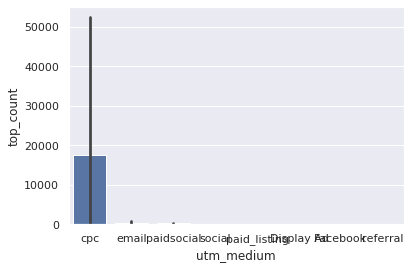

In [9]:
# Visual 


sns.set()
sns.barplot(data = non_null_values,x = 'utm_medium' ,y = 'top_count' )


# visual was Not helpful - As CPC & google dominate as medium and source.

# Final DataFrame 

In [10]:
# 23 records out of 89949 have more than one utm_source . Keeping the first occurance of utm_source to keep the data clean 

sql = """select 
anonymous_user_id,url,time,browser,os,screen_resolution,utm_medium,
ltrim(utm_source,'---') as utm_source ,
path
from source_df """

final_df = ps.sqldf(sql)
final_df.head()

,anonymous_user_id,url,time,browser,os,screen_resolution,utm_medium,utm_source,path
0,b527ad6c-1e79-4ae7-8206-2bf4d127ec25,https://preview.hs-sites.com/_hcms/p...,2018-04-12 16:50:55.000000,Chrome,Linux,800x600,None,None,/_hcms/preview/template/multi
1,2847753f-df48-4367-98dc-9028f6330532,https://www.cultureamp.com/employee-...,2018-04-12 16:16:36.000000,Chrome,Chrome OS,1366x768,cpc,google,/employee-feedback/
2,7540e6a6-bd75-4f2b-b774-6309bda47c4f,https://www.cultureamp.com/,2018-04-12 16:17:48.000000,Chrome,Mac OS X,2560x1440,None,None,/
3,db016ab6-daa3-45fb-84e6-7e6e4e1541ac,https://www.cultureamp.com/products/...,2018-04-12 16:18:33.000000,Chrome,Mac OS X,1440x900,None,None,/products/employee-engagement/
4,864557aa-10c5-4efa-a53e-33f7b8f1bd3c,https://www.cultureamp.com/employee-...,2018-04-12 16:01:47.000000,Chrome,Windows 8.1,1366x768,None,None,/employee-feedback/


# Save as JSONL - One record at a time 

In [11]:
final_df.to_json('data_jsonl_file',orient='records',lines=True)  
# Saves the file as JSONL .In order to perform record by record , low volume high velocity kind of scenario , using iteraterows 
#


In [12]:
outfile = open("data.json1", "w")
for row in final_df.iterrows():
    #print(row)
    row[1].to_json(outfile)
    outfile.write("\n")


# Lines below will be a separate step - (Separate Script)
# running in parallel along with the Save as JSONL file step .

A Proper error handling and relaible setup in AWS stack will be :
  1. Create files based on size or number to disk , 
  2. Kinesis agent will send the file Firehose ( Near realtime - Min Delay = 60 Seconds)
  3. Plug in Kinesis Analytics having kinesis Firehouse as input stream 
  4. Create a stream and pump in kinesis Analytics and use window of 1000 records as batch to get the max & min dates and unique users 
  

In [13]:
cols = ['anonymous_user_id', 'time']
jsonl_df = pd.DataFrame(columns = cols )
#print(type(jsonl_df))

def calc_metrics_window(sliced_df , row_count):
    sql = """
    select count(distinct(anonymous_user_id)) as count_distinct_id , 
    min(time) as min_time, 
    max(time) as max_time 
    from sliced_df  
    """
    out = ps.sqldf(sql)
    return out['count_distinct_id'][0], out ['min_time'][0] , out['max_time'][0]
    
    

with open('data.json1', 'rb') as input_file:
    row_count = 0 
    for line in json_lines.reader(input_file):
        new_row = {'anonymous_user_id' : line['anonymous_user_id'], 'time': pd.to_datetime((line['time']),unit='ns')}
        jsonl_df = jsonl_df.append(new_row, ignore_index=True)
        row_count = row_count + 1 
        
        if (row_count%1000 == 0):
            #break 
            v_end = row_count
            v_start = row_count - 1000
            sliced_df = jsonl_df[v_start:v_end]
            count_distinct_id, min_time , max_time = calc_metrics_window(sliced_df, row_count)
            final_metrics = {'count_distinct_id':str(count_distinct_id) ,'min_time':str(min_time), 'max_time':str(max_time) }
            #print (count_distinct_id,min_time,max_time  )
            v_append_str = str(int(row_count/1000))
            metrics_json = json.dumps(final_metrics)
            out_file_name = v_append_str+".json"
            outfile = open(out_file_name , "w")
            outfile.write(metrics_json)

            
            
            
            
            
           
                              

                
        
        